# Evaluation & Comparison

Notebook này thực hiện:
1. Kết hợp kết quả từ tất cả models
2. Xuất bảng metrics metrics.csv
3. Lưu confusion matrix và ROC curves vào thư mục results/
4. Review toàn bộ pipeline và dữ liệu


In [1]:
# ⚠️ QUAN TRỌNG: Chạy cell này TRƯỚC TIÊN để setup đường dẫn
import sys
from pathlib import Path

# Lấy project root (cha của thư mục notebooks)
project_root = Path.cwd().parent

# Add project root vào PYTHONPATH
sys.path.append(str(project_root))

print("Project root:", project_root)

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import pickle
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Import evaluation functions
from src.evaluate import (
    evaluate_model, get_metrics_dict, export_metrics_to_csv,
    plot_metrics_comparison, compare_models_roc, print_metrics
)

print(f"Project root: {project_root.absolute()}")
print("Libraries imported successfully!")

Project root: d:\Code\credit_fraud_detection
Project root: d:\Code\credit_fraud_detection
Libraries imported successfully!


In [2]:
# ⚠️ QUAN TRỌNG: Chạy cell này TRƯỚC TIÊN để setup đường dẫn
import sys
from pathlib import Path

# Lấy project root (cha của thư mục notebooks)
project_root = Path.cwd().parent

# Add project root vào PYTHONPATH
sys.path.append(str(project_root))

print("Project root:", project_root)

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import pickle
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Import evaluation functions
from src.evaluate import (
    evaluate_model, get_metrics_dict, export_metrics_to_csv,
    plot_metrics_comparison, compare_models_roc, print_metrics
)

# Import data preprocessing helpers
from src.data_preprocessing import scale_features, split_data, get_class_weights

# Import model I/O helpers
from src.models import load_model, save_model

print(f"Project root: {project_root.absolute()}")
print("Libraries imported successfully!")


Project root: d:\Code\credit_fraud_detection
Project root: d:\Code\credit_fraud_detection
Libraries imported successfully!


## 1. Load Results từ tất cả Models

Load predictions và metrics từ các models đã train trong notebook 02.


In [3]:
# Load test data for final evaluation
# Note: In practice, you would load preprocessed data from notebook 01
# For this notebook, we'll reload and preprocess everything here

# 1) Load raw data
data_path = project_root / 'data' / 'creditcard.csv'
df = pd.read_csv(data_path)

# 2) Prepare features and target
feature_cols = [f'V{i}' for i in range(1, 29)] + ['Amount']
X = df[feature_cols]
y = df['Class']

# 3) Load scaler if available, otherwise create a new one
scaler_path = project_root / 'models' / 'scaler.pkl'

if scaler_path.exists():
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    print("✓ Loaded scaler from file")
    # Apply existing scaler (do not refit)
    X_scaled, _ = scale_features(X, feature_cols=feature_cols, scaler=scaler, fit=False)
else:
    print("⚠️ Scaler file not found, creating a new scaler...")
    X_scaled, scaler = scale_features(X, feature_cols=feature_cols, fit=True)
    print("✓ Created new scaler")

# 4) Split data (same random_state as notebook 01)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    X_scaled, y,
    test_size=0.15,
    val_size=0.15,
    random_state=42,
)

print(f"\nTest set: {X_test.shape[0]:,} samples")
print(f"Test set class distribution: {y_test.value_counts().to_dict()}")


✓ Loaded scaler from file

Test set: 42,722 samples
Test set class distribution: {0: 42648, 1: 74}


In [4]:
# Load hoặc train models và lấy predictions
# - Nếu đã có file trong models/ => load và skip training
# - Nếu chưa có => train, rồi save để lần sau chạy nhanh hơn

from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

models_dir = project_root / 'models'
models_dir.mkdir(exist_ok=True)

def _model_path(model_name: str) -> Path:
    filename = model_name.lower().replace(' ', '_') + '.pkl'
    return models_dir / filename

def load_if_exists(model_name: str):
    model_path = _model_path(model_name)
    if model_path.exists():
        print(f"⏭️ Skip train: loaded {model_path.name}")
        return load_model(model_name, model_dir=models_dir)
    return None

# Get class weights
class_weights = get_class_weights(y_train)

# Dictionary to store all results
all_results = {
    'y_true': y_test,  # Use test set for final evaluation
    'predictions': {},
    'probabilities': {},
    'metrics': [],
}


In [5]:
# Model 1: Logistic Regression
lr_model = load_if_exists('Logistic Regression')
if lr_model is None:
    print("Training Logistic Regression...")
    lr_model = LogisticRegression(class_weight=class_weights, random_state=42, max_iter=1000)
    lr_model.fit(X_train, y_train)
    save_model(lr_model, 'Logistic Regression', save_dir=models_dir)
all_results['predictions']['Logistic Regression'] = lr_model.predict(X_test)
all_results['probabilities']['Logistic Regression'] = lr_model.predict_proba(X_test)[:, 1]

# Model 2: Random Forest
rf_model = load_if_exists('Random Forest')
if rf_model is None:
    print("Training Random Forest...")
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        class_weight=class_weights,
        random_state=42,
        n_jobs=-1,
    )
    rf_model.fit(X_train, y_train)
    save_model(rf_model, 'Random Forest', save_dir=models_dir)
all_results['predictions']['Random Forest'] = rf_model.predict(X_test)
all_results['probabilities']['Random Forest'] = rf_model.predict_proba(X_test)[:, 1]

# Model 3: AdaBoost
ada_model = load_if_exists('AdaBoost')
if ada_model is None:
    print("Training AdaBoost...")
    ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)
    ada_model.fit(X_train, y_train)
    save_model(ada_model, 'AdaBoost', save_dir=models_dir)
all_results['predictions']['AdaBoost'] = ada_model.predict(X_test)
all_results['probabilities']['AdaBoost'] = ada_model.predict_proba(X_test)[:, 1]

# Optional: XGBoost (nếu đã train/saved từ notebook 02)
xgb_model = load_if_exists('XGBoost')
if xgb_model is not None:
    all_results['predictions']['XGBoost'] = xgb_model.predict(X_test)
    all_results['probabilities']['XGBoost'] = xgb_model.predict_proba(X_test)[:, 1]

print("\n✓ Predictions generated (trained and/or loaded)")


⏭️ Skip train: loaded logistic_regression.pkl
✅ Model loaded from d:\Code\credit_fraud_detection\models\logistic_regression.pkl
⏭️ Skip train: loaded random_forest.pkl
✅ Model loaded from d:\Code\credit_fraud_detection\models\random_forest.pkl
⏭️ Skip train: loaded adaboost.pkl
✅ Model loaded from d:\Code\credit_fraud_detection\models\adaboost.pkl
⏭️ Skip train: loaded xgboost.pkl
✅ Model loaded from d:\Code\credit_fraud_detection\models\xgboost.pkl

✓ Predictions generated (trained and/or loaded)


## 2. Kết hợp và So sánh Metrics


In [6]:
# Calculate metrics for all models
y_true = all_results['y_true']

for model_name in all_results['predictions'].keys():
    y_pred = all_results['predictions'][model_name]
    y_pred_proba = all_results['probabilities'][model_name]
    
    metrics = get_metrics_dict(y_true, y_pred, y_pred_proba, model_name)
    all_results['metrics'].append(metrics)
    print_metrics(y_true, y_pred, y_pred_proba, model_name)

# Create comparison DataFrame
metrics_df = pd.DataFrame(all_results['metrics'])
print("\n" + "="*70)
print("Metrics Comparison - All Models")
print("="*70)
print(metrics_df.to_string(index=False))
print("="*70)



Metrics for Logistic Regression
Accuracy:  0.9761
Precision: 0.0612
Recall:    0.8919
F1 Score:  0.1146
AUC:       0.9630


Metrics for Random Forest
Accuracy:  0.9994
Precision: 0.8852
Recall:    0.7297
F1 Score:  0.8000
AUC:       0.9649


Metrics for AdaBoost
Accuracy:  0.9990
Precision: 0.7123
Recall:    0.7027
F1 Score:  0.7075
AUC:       0.9694


Metrics for XGBoost
Accuracy:  0.9992
Precision: 0.7703
Recall:    0.7703
F1 Score:  0.7703
AUC:       0.9777


Metrics Comparison - All Models
 accuracy  precision   recall       f1      auc               model
 0.976125   0.061224 0.891892 0.114583 0.962982 Logistic Regression
 0.999368   0.885246 0.729730 0.800000 0.964897       Random Forest
 0.998993   0.712329 0.702703 0.707483 0.969383            AdaBoost
 0.999204   0.770270 0.770270 0.770270 0.977721             XGBoost


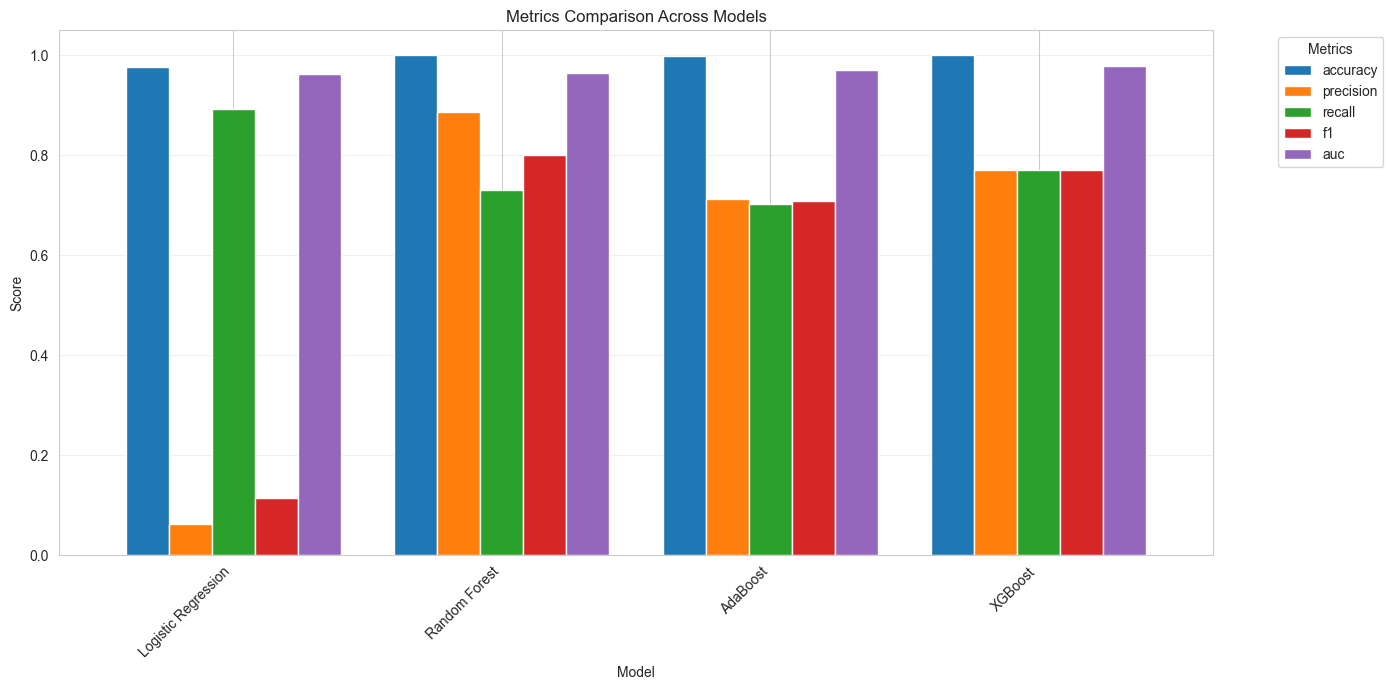

In [7]:
# Visualize metrics comparison
fig = plot_metrics_comparison(all_results['metrics'], figsize=(14, 7))
plt.show()


## 3. Xuất metrics.csv


In [8]:
# Export metrics to CSV
metrics_csv_path = project_root / 'results' / 'metrics.csv'
export_metrics_to_csv(all_results['metrics'], metrics_csv_path)

# Display the saved CSV
print("\nSaved metrics:")
print(pd.read_csv(metrics_csv_path).to_string(index=False))


Metrics exported to d:\Code\credit_fraud_detection\results\metrics.csv

Saved metrics:
              model  accuracy  precision   recall       f1      auc
Logistic Regression  0.976125   0.061224 0.891892 0.114583 0.962982
      Random Forest  0.999368   0.885246 0.729730 0.800000 0.964897
           AdaBoost  0.998993   0.712329 0.702703 0.707483 0.969383
            XGBoost  0.999204   0.770270 0.770270 0.770270 0.977721


## 4. Lưu Confusion Matrices


Confusion matrix saved to d:\Code\credit_fraud_detection\results\confusion_matrices\Logistic_Regression_confusion_matrix.png


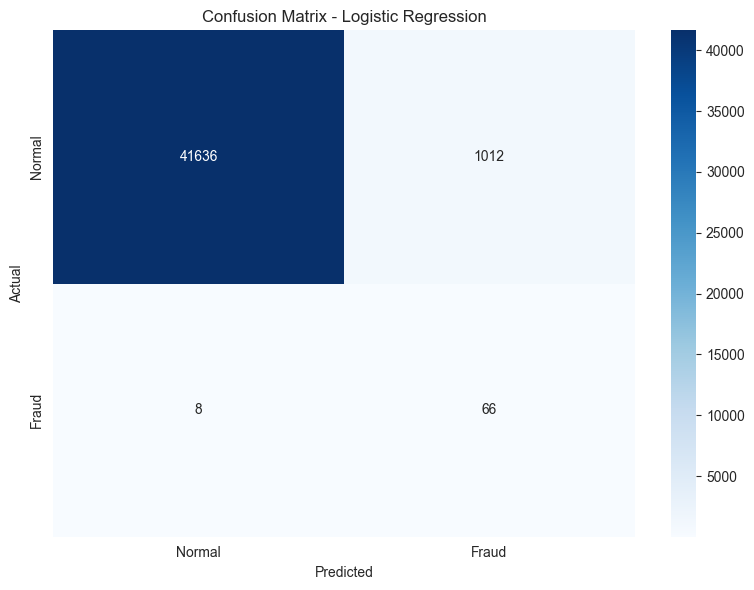

Confusion matrix saved to d:\Code\credit_fraud_detection\results\confusion_matrices\Random_Forest_confusion_matrix.png


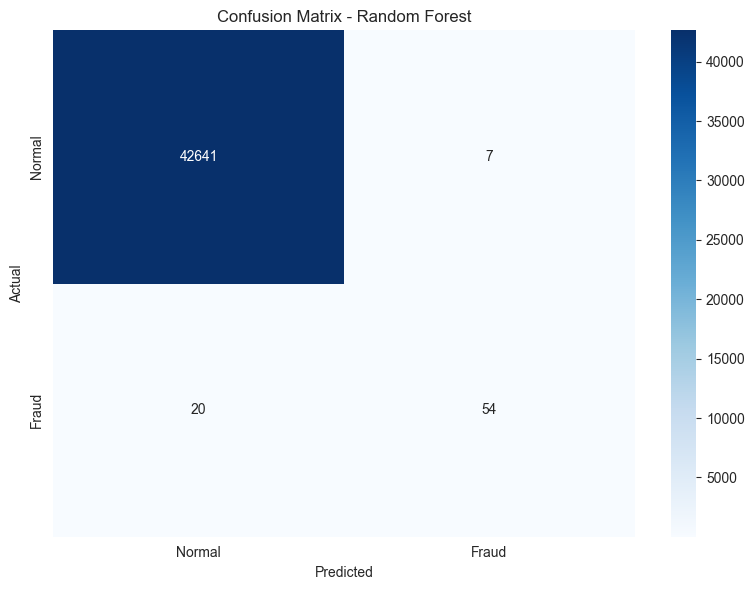

Confusion matrix saved to d:\Code\credit_fraud_detection\results\confusion_matrices\AdaBoost_confusion_matrix.png


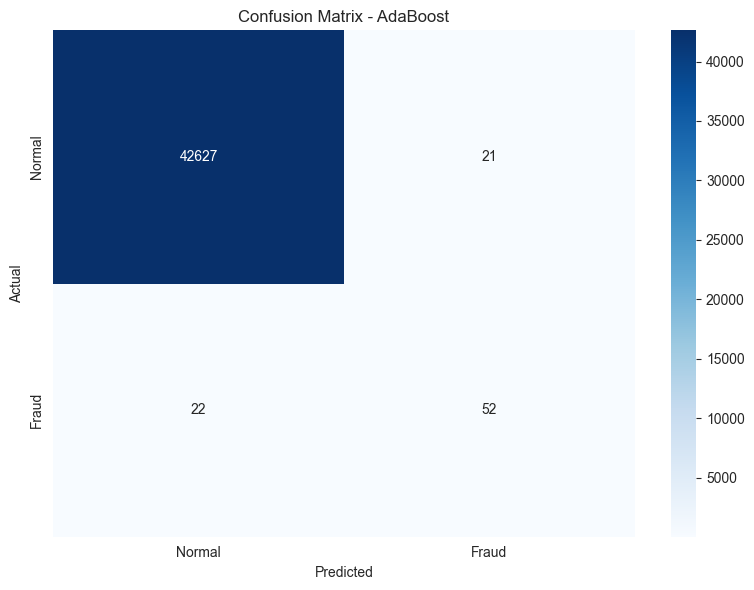

Confusion matrix saved to d:\Code\credit_fraud_detection\results\confusion_matrices\XGBoost_confusion_matrix.png


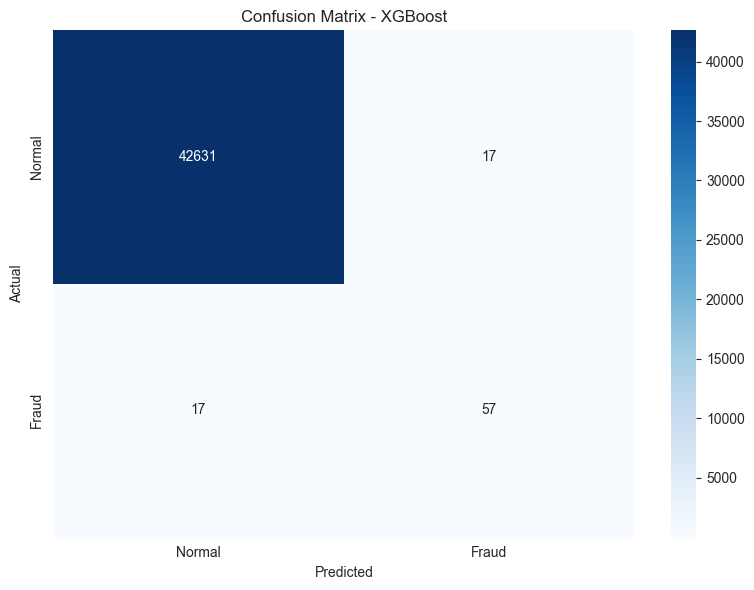


✓ All confusion matrices saved to d:\Code\credit_fraud_detection\results\confusion_matrices


In [9]:
# Create directory for confusion matrices
confusion_matrix_dir = project_root / 'results' / 'confusion_matrices'
confusion_matrix_dir.mkdir(parents=True, exist_ok=True)

# Generate and save confusion matrices for all models
from src.evaluate import plot_confusion_matrix

for model_name in all_results['predictions'].keys():
    y_pred = all_results['predictions'][model_name]
    save_path = confusion_matrix_dir / f'{model_name.replace(" ", "_")}_confusion_matrix.png'
    
    fig = plot_confusion_matrix(
        y_true, y_pred, 
        model_name=model_name,
        save_path=save_path
    )
    plt.show()
    plt.close(fig)

print(f"\n✓ All confusion matrices saved to {confusion_matrix_dir}")


## 5. Lưu ROC Curves


ROC curves comparison saved to d:\Code\credit_fraud_detection\results\roc_curves_comparison.png


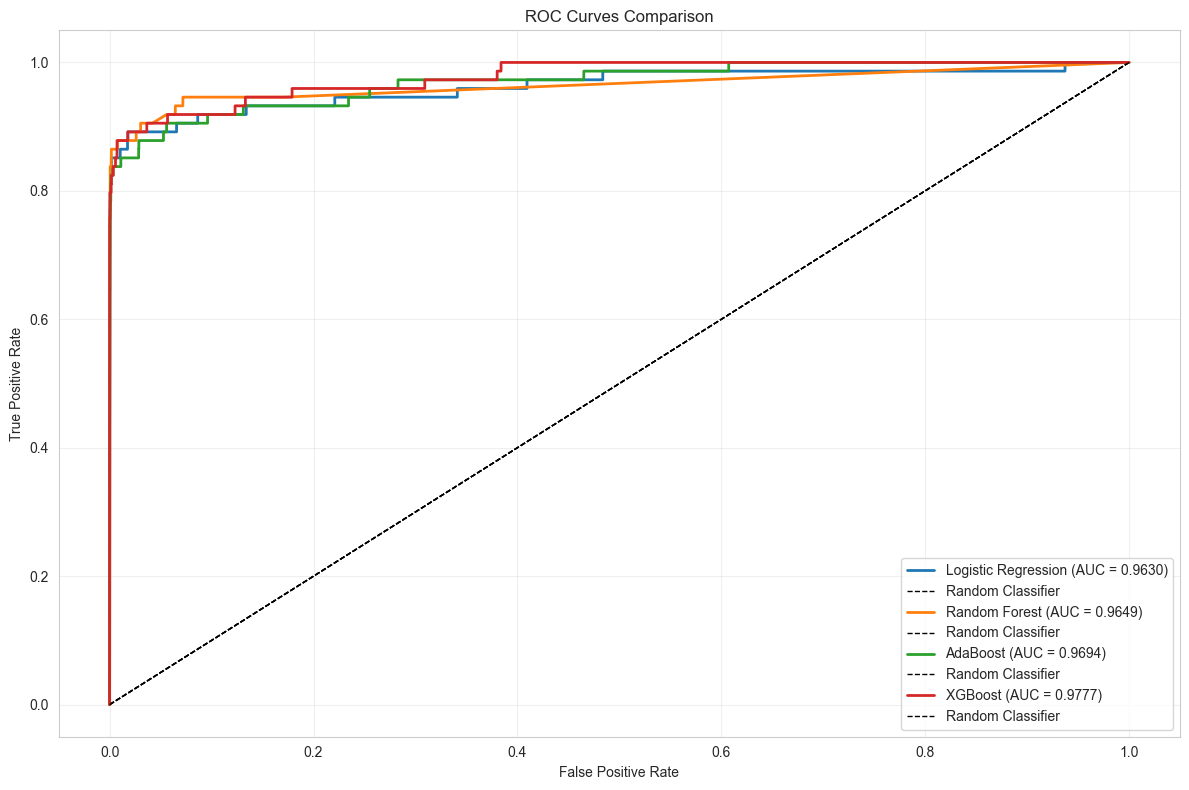


✓ ROC curves comparison saved to d:\Code\credit_fraud_detection\results\roc_curves_comparison.png


In [10]:
# Prepare data for ROC comparison
y_true_dict = {model_name: y_true for model_name in all_results['probabilities'].keys()}
y_pred_proba_dict = all_results['probabilities']

# Plot ROC curves comparison
roc_save_path = project_root / 'results' / 'roc_curves_comparison.png'
fig = compare_models_roc(y_true_dict, y_pred_proba_dict, roc_save_path, figsize=(12, 8))
plt.show()
plt.close(fig)

print(f"\n✓ ROC curves comparison saved to {roc_save_path}")


## 6. Tổng hợp và So sánh

Review toàn bộ pipeline và dữ liệu.


In [11]:
# Summary statistics
print("="*70)
print("EVALUATION SUMMARY")
print("="*70)

print(f"\nTotal models evaluated: {len(all_results['metrics'])}")
print(f"Test set size: {len(y_true):,} samples")
print(f"Test set fraud cases: {y_true.sum():,} ({y_true.sum()/len(y_true)*100:.2f}%)")

print("\n" + "-"*70)
print("Best Model by Metric:")
print("-"*70)

metrics_df = pd.DataFrame(all_results['metrics'])

for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    if metric in metrics_df.columns and metrics_df[metric].notna().any():
        best_idx = metrics_df[metric].idxmax()
        best_model = metrics_df.loc[best_idx, 'model']
        best_value = metrics_df.loc[best_idx, metric]
        print(f"{metric.capitalize():12s}: {best_model:25s} ({best_value:.4f})")

print("\n" + "="*70)
print("Pipeline Review:")
print("="*70)
print("✓ Data preprocessing: Scaling, train/val/test split completed")
print("✓ Class imbalance handling: Class weights applied")
print("✓ Models trained and evaluated on test set")
print("✓ Metrics calculated and exported to CSV")
print("✓ Confusion matrices saved")
print("✓ ROC curves comparison saved")
print("="*70)


EVALUATION SUMMARY

Total models evaluated: 4
Test set size: 42,722 samples
Test set fraud cases: 74 (0.17%)

----------------------------------------------------------------------
Best Model by Metric:
----------------------------------------------------------------------
Accuracy    : Random Forest             (0.9994)
Precision   : Random Forest             (0.8852)
Recall      : Logistic Regression       (0.8919)
F1          : Random Forest             (0.8000)
Auc         : XGBoost                   (0.9777)

Pipeline Review:
✓ Data preprocessing: Scaling, train/val/test split completed
✓ Class imbalance handling: Class weights applied
✓ Models trained and evaluated on test set
✓ Metrics calculated and exported to CSV
✓ Confusion matrices saved
✓ ROC curves comparison saved



Final Metrics Table:
 accuracy  precision   recall       f1      auc               model
 0.976125   0.061224 0.891892 0.114583 0.962982 Logistic Regression
 0.999368   0.885246 0.729730 0.800000 0.964897       Random Forest
 0.998993   0.712329 0.702703 0.707483 0.969383            AdaBoost
 0.999204   0.770270 0.770270 0.770270 0.977721             XGBoost
Metrics comparison chart saved to d:\Code\credit_fraud_detection\results\metrics_comparison.png


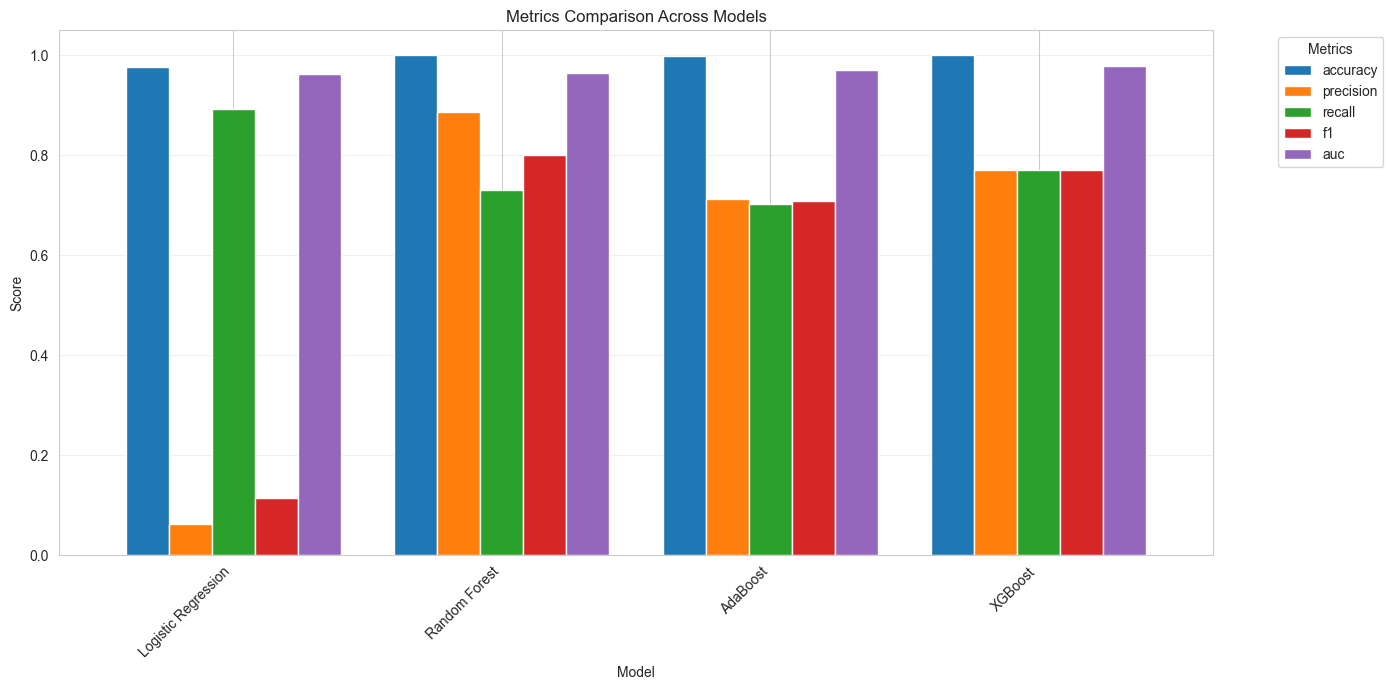


✓ Metrics comparison chart saved to d:\Code\credit_fraud_detection\results\metrics_comparison.png

✅ Evaluation and Comparison completed successfully!


In [12]:
# Display final metrics table
print("\nFinal Metrics Table:")
print(metrics_df.to_string(index=False))

# Save comparison chart
comparison_chart_path = project_root / 'results' / 'metrics_comparison.png'
fig = plot_metrics_comparison(all_results['metrics'], comparison_chart_path, figsize=(14, 7))
plt.show()
plt.close(fig)

print(f"\n✓ Metrics comparison chart saved to {comparison_chart_path}")
print("\n✅ Evaluation and Comparison completed successfully!")
